# Visualization of Thomas Fire Impact on Air and Land Quality in Santa Barbara

Amanda Herbst

**Link to GitHub repository:** https://github.com/amandaherbst/eds220-thomas-fire

![Thomas fire](thomas-fire-image.jpeg)

## About the Analysis

### Background

The Thomas fire was a huge wildfire that burned a large part of Santa Barbara and Ventura counties during December 2017, and was the largest recorded California wildfire at the time. Residents of both counties and beyond were greatly affected by the destruction of their homes, widespread evacuations, and schools shutting down. The following analysis gives insight on the drastic impacts the Thomas fire had on the local air quality, as well as the land area it burned.

### Highlights of Analysis
- Fetch vector data from an online repository
- Time series analysis
- Visualize raster data
- False color imagery
- Plotting with `Matplotlib.pyplot`

### Datasets:

**(1) Air Quality Index (AQI)**

Outdoor daily air quality measurements in US counties can be retrieved from the US Environmental Protection Agency (EPA). It can then be filtered to a county (or counties) of interest--in this case, Santa Barbara county.

**(2) Landsat raster data**

The raster data was accessed and preprocessed in the Microsoft Planetary Computer from their Landsat Collection 2 Level-2 dataset. It contains a simplified collection of red, green, blue, near-infrared, and shortwave infrared bands that were collected by the Landsat 8 satellite.

**(3) CA Fire Perimeters**

Since the majority of the Thomas Fire burned during December 2017, I accessed the shapefiles of fire perimeters in California during 2017, provided by CAL FIRE. 

### References

US Environmental Protection Agency (2023). *Daily AQI by County* [Data File]. Available from https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI. Accessed October 25, 2023

Microsoft Planetary Computer. *Landsat Collection 2 Level-2* [Dataset]. Available from https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2. Accessed November 28, 2023

California Department of Forestry and Fire Protection (2023). *California Fire Perimeters (all)* [Data File]. Available from https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about. Accessed November 28, 2023

## Importing Libraries and Functions

In [1]:
import os
import pandas as pd

import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

## Importing the Data

The air quality data can be accessed via URL. The Landsat raster data and California fire perimeters were downloaded and stored in a local folder which is accessed directly. 

In [2]:
# 2017 and 2018 air quality data
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip')
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip')

# import landsat raster data by calling a filepath with os
landsat = rioxr.open_rasterio(os.path.join(os.getcwd(),'data', 'landsat8-2018-01-26-sb-simplified.nc'))

# ca fire perimeters
ca_fire = gpd.read_file('data/California_Fire_Perimeters_2017/California_Fire_Perimeters_2017.shp')

## Geographical context of data

Santa Barbara county is located on the coast of Southern California (coordinates: 34.6099° N, 120.0665° W) and has a Mediterranean biome that has recently experienced prolonged droughts and is prone to wildfires. 

## Analyzing Impact on Air Quality

On December 4, 2017 some particularly high winds created an electrical arc between multiple power lines and the Thomas Fire resulted, burning for a month and a half. As the fire made its way up the coast of California, it blanketed the surrounding cities in a thick cloud of smoke and ash. The following analyis visualizes the air quality in Santa Barbara county during 2017 and 2018.

### Air Quality Data Preparation

The air quality data I acquired from the US EPA includes all counties, so it needs to be filtered to Santa Barbara county in addition to general tidying of column names. Tidying and converting the date column to the index is useful for plotting, as well as calculating a rolling average.


In [3]:
# join the aqi datasets together
aqi = pd.concat([aqi_17, aqi_18])

# tidy aqi column names
aqi.columns = aqi.columns.str.lower().str.replace(' ','_')

# filter by county name, only keeping necessary columns
aqi_sb = aqi[aqi.county_name == 'Santa Barbara'].loc[:,'date':'number_of_sites_reporting']

# convert date column from string to timestamps
aqi_sb.date = pd.to_datetime(aqi_sb.date)

# set the date column to be the index
aqi_sb = aqi_sb.set_index('date')

# create new column to store the rolling 5 day averages of AQI
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()

## Plot: Santa Barbara County AQI 2017-2018

The following plot shows the daily air quality (light green) in Santa Barbara county from 2017 - 2018 as well as a 5-day rolling average (dark green) to demonstrate mean AQI levels on a 5 day scale.

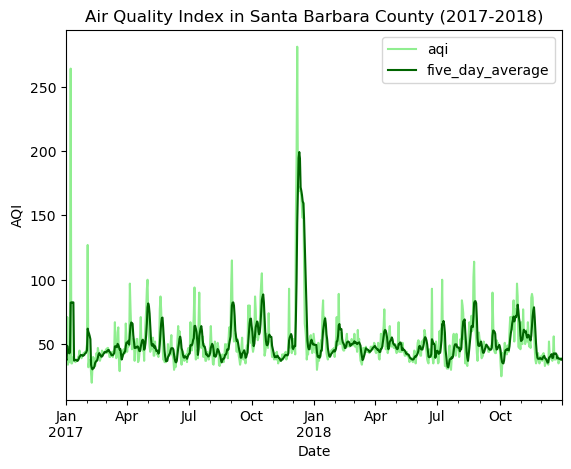

In [11]:
# plot daily AQI and 5-day average with updated labels, title, and colors
aqi_sb.plot(y = ['aqi', 'five_day_average'],
            xlabel = 'Date',
            ylabel = 'AQI',
            color = {'aqi':'lightgreen',
                    'five_day_average':'darkgreen'},
            title = 'Air Quality Index in Santa Barbara County (2017-2018)')

plt.show()

We can see a huge spike in December 2017 that coincides with the timeline of the Thomas Fire. According to [AirNow](https://www.airnow.gov/aqi/aqi-basics/), an AQI above 150 is considered Unhealthy for the general population, and over 200 is Very Unhealthy. The daily measurements during the Thomas Fire peak at well over 250, and the average measurements peak at 200. Therefore, most if not all, residents of Santa Barbara county were exposed to very high health risks for the duration of the Thomas Fire.

## Mapping Fire Perimeter and Impact on Land Quality

In total, the Thomas Fire burned 281,893 acres over 40 days. When heavy rainfall came down in the early hours of January 9th, 2018, the recently burned, and therefore destabilized, foothills of Santa Barbara crumbled and led to a devastating mudslide in the town of Montecito. The following analysis will visualize the full perimeter of the fire, along with the burn scar it left behind. 

### Data Cleaning

#### Raster Preparation

The Landsat raster data contains an extra band and coordinates that are not necessary for this analysis so we will drop them for more efficient processing.

In [5]:
# drop extra dimension 
landsat = landsat.squeeze().drop('band')

#### Fire Perimeter Preparation

The CA fire perimeter shapefiles require some tidying before we reproject to the same coordinate reference system (CRS) as the Landsat raster data. Reprojection is necessary for accurate plotting. The final step is selecting our fire of interest--the Thomas Fire.

In [6]:
# update ca_fire column names to lowercase
ca_fire.columns = ca_fire.columns.str.lower()

# Reproject shapefile to raster CRS for plotting
ca_fire = ca_fire.to_crs(landsat.rio.crs)

# select thomas fire from ca fire perimeters for easier plotting
thomas = ca_fire[ca_fire.fire_name == "THOMAS"]

## Map: Thomas Fire Perimeter and Burn Scar

We will map the Thomas Fire perimeter (in red) on top of a false color image of Santa Barbara County. We are using the shortwave infrared, near-infrared, and red bands from the Landsat raster. With this combination of bands, we will be able to clearly see any burned area in red.

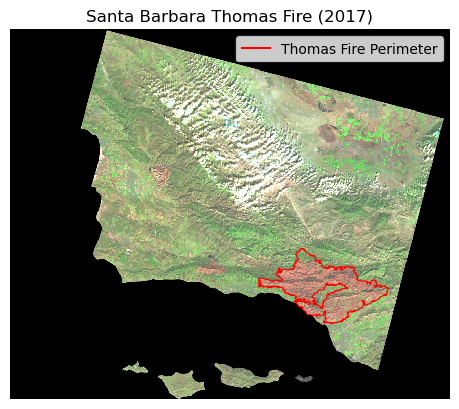

In [10]:
# map false color image with thomas fire perimeter
fig, ax = plt.subplots()

# plot false color image
landsat[['swir22','nir08','red']].to_array().plot.imshow(robust = True,
                                                        ax = ax)
# plot thomas fire perimeter in red
thomas.boundary.plot(ax = ax,
            color = "red",
                    linewidth = 0.8)

# create thomas fire patch for legend
thomas_patch = mlines.Line2D([],[],
                             color = "red",
                             linestyle = "-",
                             label = "Thomas Fire Perimeter")

# add legend to label thomas fire perimeter
ax.legend(handles = [thomas_patch], 
          frameon = True,
         loc = 'upper right')

# add map title
plt.title('Santa Barbara Thomas Fire (2017)')

# turn off axes
ax.axis('off')

plt.show()

The Thomas Fire perimeter almost perfectly encompasses the burn scar it left behind, which is the large area colored red. 

## Conclusion

Let's take one last look at our analysis results: 

![SB AQI](sb_aqi.png) ![Thomas Fire Map](thomas_fire_map.png)

The Thomas Fire had a very large impact on Santa Barbara county both while it was burning, and after it was finally contained. We saw a huge spike in the air quality--at unhealthy and very unhealthy levels during December 2017. Additionally, the fire left a huge burn scar that consequently led to another devastating natural disaster.